<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_NN_LDS_to_OccupancyMap_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: NN prediction of Occupancy Map from LDS (v3)
The first version had a number of problems:
* Very slow to execute (takes about 2 mins to train on TPU for just 5 epochs across 1000 samples each)
* Performs very poorly

In v2 of this notebook I looked at different network architectures and concluded that the basic UNet with skip connections merged by concatenation is not considerably slower than any other options and performs with the best results. So I'm going to stick with that for now.

In this notebook I'll experiment with ways to improve the loss function.

In [6]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout e278a71
!cd repo && git pull

import sys
sys.path.append('repo')

import lds
import map_from_lds_train_data
import unet
from importlib import reload
reload(lds)
reload(map_from_lds_train_data)
reload(unet)

HEAD is now at 47c53e7 Merge remote-tracking branch 'refs/remotes/origin/main'
Already up to date.


<module 'unet' from '/content/repo/unet.py'>

In [7]:
!pip install -Uqq ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.1 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import cv2
import requests
import math
import ipdb
from timeit import default_timer as timer

In [9]:
floorplan = Image.open('repo/data/experimental-floorplan1.png')
floorplan = np.array(floorplan, dtype=bool)
print(f"floorplan: shape={floorplan.shape}, dtype={floorplan.dtype}")

floorplan: shape=(84, 94), dtype=bool


## Helper functions

In [30]:
def display_history(history):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(model_history.history["loss"])
  plt.title("Loss")
  plt.subplot(1,2,2)
  plt.plot(model_history.history["accuracy"])
  plt.title("Accuracy")

def show_prediction(display_list, titles):
    plt.figure(figsize=(10, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

def show_predictions(model, dataset, num=1, show_probs=False):
    """
    Displays the first image of each of the num batches
    """
    for image, ground_truth in dataset.take(num):
        batch = np.expand_dims(image, axis=0)
        batch_pred = model.predict(batch)
        pred = tf.argmax(batch_pred, axis=-1)[0]

        if show_probs:
          show_prediction([image, ground_truth, pred], ['LDS Data', 'Ground Truth', 'Predicted'])
        else:
          # convert from logits to probs
          probs = tf.nn.softmax(batch_pred[0], axis=-1)
          print(f"Class 0 logit range - {tf.reduce_min(probs[:, :, 0])}, {tf.reduce_max(probs[:, :, 0])}")
          print(f"Class 1 logit range - {tf.reduce_min(probs[:, :, 1])}, {tf.reduce_max(probs[:, :, 1])}")
          class0_prob = probs[:, :, 0]
          class1_prob = probs[:, :, 1]
          show_prediction([image, ground_truth, pred, class0_prob, class1_prob], ['LDS Data', 'Ground Truth', 'Predicted', 'Class 0', 'Class 1'])

## Training data
Just fetch the pre-generated training data.

In [22]:
# If generated data is available then load that to save time:
loaded = np.load('repo/data/experimental-lds-training-data1.npz')
X = loaded['X']
Y = loaded['Y']
print(f"X: {len(X)} x {X[0].shape}")
print(f"Y: {len(Y)} x {Y[0].shape}")

# Make available for training
dataset = tf.data.Dataset.from_tensor_slices((X, Y))

X: 1000 x (105, 105)
Y: 1000 x (105, 105)


# Baseline
Setup our simple model.
And then let's get a sample result for a baseline.

In [13]:
data_shape = next(iter(dataset))[0].shape
input_size = (data_shape[0], data_shape[1], 1)
n_filters=32
n_classes=2

unet = unet.unet_model(input_size, n_filters, n_classes)

Input size: (105, 105, 1)
Added padding layer: w=7, h=7
Skip-connection merge mode: concat
Added final cropping layer: w=7, h=7


In [14]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 20
batch_size = 32
train_dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = unet.fit(train_dataset, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 502ms/step - accuracy: 0.8940 - loss: 0.3136
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9763 - loss: 0.0874
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.9764 - loss: 0.0844
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.9762 - loss: 0.0820
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.9768 - loss: 0.0779
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9769 - loss: 0.0752
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9775 - loss: 0.0727
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.9781 - loss: 0.0676
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9791 - loss: 0.0646
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9792 - loss: 0.0623
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.9801 - loss: 0.0596
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/ste

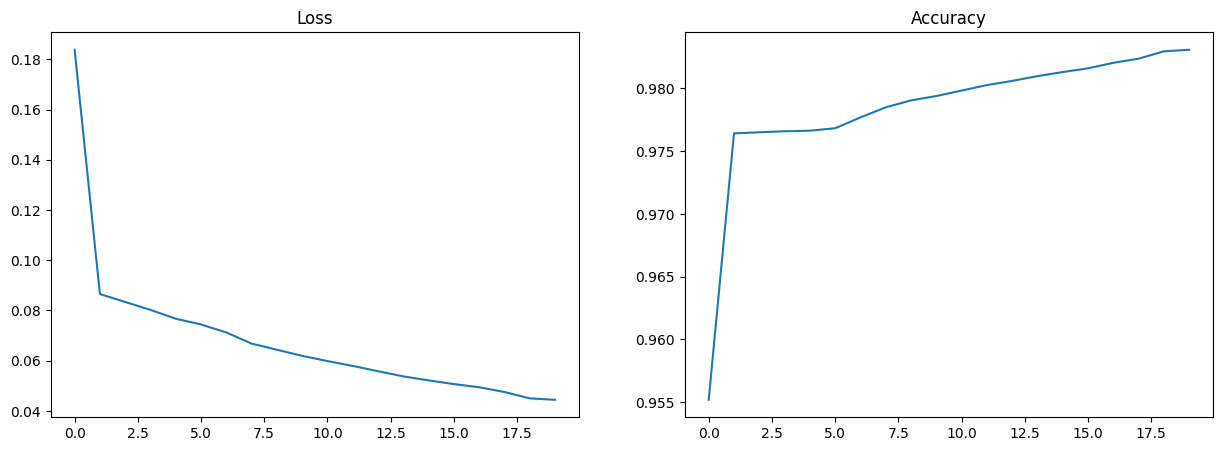

In [18]:
display_history(model_history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class 0 logit range - 1.730965436763654e-06, 1.0
Class 1 logit range - 1.9971484252397246e-20, 0.9999982118606567


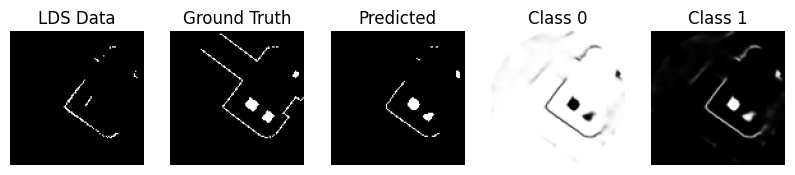

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class 0 logit range - 1.0146331078431103e-05, 1.0
Class 1 logit range - 2.4496040084077276e-32, 0.9999898672103882


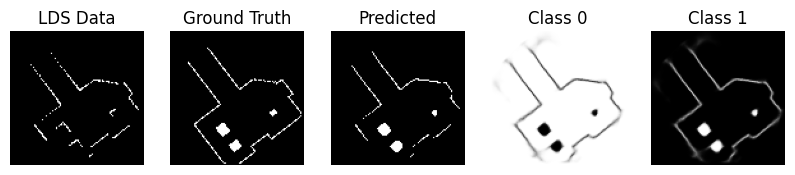

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Class 0 logit range - 4.206240919302218e-05, 1.0
Class 1 logit range - 2.067851481247888e-28, 0.9999579191207886


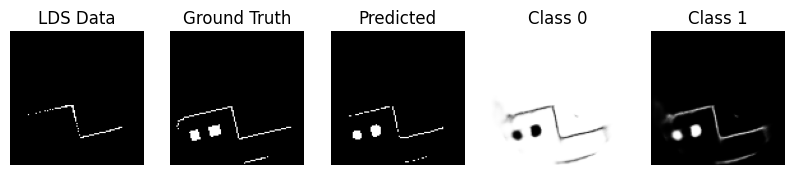

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Class 0 logit range - 0.0018324308330193162, 1.0
Class 1 logit range - 2.5589218973615295e-31, 0.9981675148010254


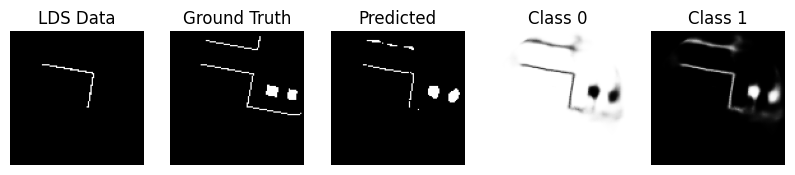

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Class 0 logit range - 0.0016346984775736928, 1.0
Class 1 logit range - 9.338006306787786e-15, 0.9983653426170349


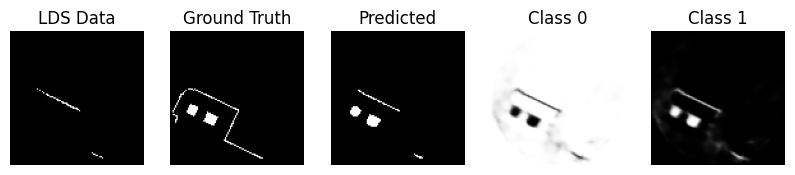

In [31]:
show_predictions(unet, dataset, 5)